## Notebook Contents

0. Introduction
1. Data Processing and Loading
2. Model Training
3. Model Usage
4. Model Evaluation

## 0. Introduction

Here, we are going to replicate the VolGAN-example file, by demonstrating the modifications we are making to the VolGAN file and introducing new functions we have created.

In [3]:
#import libraries

import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import warnings
import torch.nn as nn
warnings.filterwarnings("ignore")

#import files with supporting functions
import VolGANSwaps as VGS
import Inputs

#import our data sets and a sample date for testing
VOLATILITY_DATA = "data/swaption_atm_vol_full_NEW_no30y.xlsx"
FORWARDS_DATA = "data/forward_sofr_swap_full_NEW_no30y.xlsx"

## 1. Data Processing and Loading

### 1.1 Data Loading
- The data loader takes in the filepath to the volatility surface and the forward swap rates
- Constructs returns on underlying
- Processes the volatility data
    - The surface for every underlying asset is represented as a vector
    - This is similarly the case for the returns
- Sets up the tenor and tau matrices

In [4]:
surfaces_transform, returns, tenor, tau, tenors, taus, dates_dt = VGS.SwapsData(FORWARDS_DATA, VOLATILITY_DATA)

### 1.2 Data Preprocessing

- Within `DataPreprocessing` we call `SwapsData` like the original VolGAN implementation
- Here we construct the condition vector, construct the true labels and pass through some other data that might be relevant
    - Each underlying has a condition vector and the true labels (annualized return and log implied vol increment)
    - Because of this they will actually end up being tensor inputs to the models

In [5]:
true, condition, m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataPreprocesssing(FORWARDS_DATA, VOLATILITY_DATA, data_model='normal')

### 1.3 Data Train Test Split
- Separates dataset into train and test datasets after processing and loading
- Parameterized by datasize percentage / proportion
- Parameterized by a data transformation assumption (`normal` or `log`)
    - Not directly related to volatility model assumptions 

In [5]:
true_train, true_test, condition_train,  condition_test,  m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataTrainTest(FORWARDS_DATA, VOLATILITY_DATA, 0.8, data_model='normal')

## 2. Model Training

We updated the two training loops in the paper by ensuring the dimensionality of the computations were correct.
- We reproduce the training process described in the paper in both hyper parameters and process
- We also provide the workflow for doing individual experiments which includes tuning of any training parameters. 

### 2.1 Reproduce the Paper

We first highlight the original training architecture and structure as the paper. 

For reference, this procedure is described in section 3.4 in the original paper.

The hyperparameters are also exactly those provided in `VolGAN-example.py` from the original repo.

In [6]:
tr = 0.85
noise_dim = 32
hidden_dim = 16
n_epochs = 10000
n_grad = 25
val = True
data_model = 'normal'

The models can be trained on either gpu or cpu.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Here is the full training process.

The `VolGAN` function completes the entirety of the training, including the gradient matching procedure.

In [ ]:
gen, gen_opt, disc, disc_opt, true_train, true_val, true_test, condition_train, condition_val, condition_test, dates_t,  tenor, tau, tenors, taus  = VGS.VolGAN(FORWARDS_DATA,VOLATILITY_DATA, tr, noise_dim = noise_dim, hidden_dim = hidden_dim, n_epochs = n_epochs,n_grad = n_grad, lrg = 0.0001, lrd = 0.0001, batch_size = 100, device = device, data_model=data_model)

100%|██████████| 250/250 [01:24<00:00,  2.96it/s]


alpha : 5.603299108894575e-06 beta : 0.0009115327179608878


100%|██████████| 10000/10000 [50:54<00:00,  3.27it/s] 


### 2.2 Modifying the Training Process

The `VolGANSwaps` directly abstracts the training process just to highlight the reproduced paper.

Any experiments to modify can be done by modifying the exact code framework that is contained in the function.

This can include but is not limited to the following:
- Manual selection of $\alpha_{\text{tenor}}$ and $\alpha_\tau$
    - Setting $\alpha_{\text{tenor}} = \alpha_\tau = 0$ results in the traditional GAN setting with only BCE loss contributing to the optimization
    - Contrary to what the paper says the `beta` selected in the code is actually $\alpha_\tau$ and `alpha` is $\alpha_{\text{tenor}}$
- Manual selection of optimizer
    - RMSProp, Adam, AdamW, etc.
- Manual selection of layer dimensions (noise and hidden)
- Manual selection for training time
- Manual selection for train/test split
- Manual selection for learning rates
- Manual selection for data transformation

In [9]:
tr = 0.8
noise_dim = 16
hidden_dim = 32
device = 'cpu'
val = True
data_model = 'log'
lrg = 0.0001
lrd = 0.0001
batch_size = 100
n_epochs = 5000

# we skip the gradient matching and directly choose alpha, beta
# alpha = beta = 0 is traditional GAN training

n_grad = 0
alpha = 0
beta = 0

In [ ]:
SURFACE_PATH = "data/swaption_atm_vol_full_no30y.xlsx"
DATA_PATH = "data/forward_sofr_swap_full_no30y.xlsx"

surfaces_transform, returns, tenor, tau, tenors, taus, dates_dt = VGS.SwapsData(DATA_PATH, SURFACE_PATH)
true, condition, m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataPreprocesssing(DATA_PATH, SURFACE_PATH)

In [ ]:
true_train, true_test, condition_train, condition_test,  m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataTrainTest(FORWARDS_DATA, VOLATILITY_DATA, tr, data_model, device)

gen = VGS.Generator(noise_dim=noise_dim,cond_dim=condition_train.shape[2], hidden_dim=hidden_dim,output_dim=true_train.shape[2],mean_in = m_in, std_in = sigma_in, mean_out = m_out, std_out = sigma_out)
gen.to(device)

# m_disc and sigma_disc are not used in the original VolGAN, you can see in the Discriminator forward function 
# we'll preserve the forward pass for now but we can maybe incorporate these later if needed    
m_disc = torch.cat((m_in,m_out),dim=-1)
sigma_disc = torch.cat((sigma_in,sigma_out),dim=-1)

disc = VGS.Discriminator(in_dim = condition_train.shape[2] + true_train.shape[2], hidden_dim = hidden_dim, mean = m_disc, std = sigma_disc)
disc.to(device)

true_val = False
condition_val = False

gen_opt = torch.optim.AdamW(gen.parameters(), lr=lrg)
disc_opt = torch.optim.AdamW(disc.parameters(), lr=lrd)

criterion = nn.BCELoss()
criterion = criterion.to(device)

In [6]:
gen,gen_opt,disc,disc_opt,criterion = VGS.TrainLoopNoVal(alpha,beta,gen,gen_opt,disc,disc_opt,criterion,condition_train,true_train,tenor,tau,tenors,taus,n_epochs,lrg,lrd,batch_size,noise_dim,device, data_model=data_model)

100%|██████████| 5000/5000 [15:15<00:00,  5.46it/s]


### 2.3 Exporting Model Parameters

In [8]:
gen_filepath = 'model/generator_parameters.pth'
disc_filepath = 'model/discriminator_parameters.pth'

torch.save(gen.state_dict(), gen_filepath)
torch.save(disc.state_dict(), disc_filepath)

## 3. Model Usage

Once a trained model has been exported, in this section we'll show how to load the model and utilize the generator to produce surfaces and returns.

### 3.1 Loading Model Parameters

You must ensure the hyperparameters from the original training process be matched with the model objects so that the model parameters can be loaded in properly.

In [43]:
tr = 0.8
noise_dim = 16
hidden_dim = 32
device = 'cpu'
val = True
data_model = 'log'
lrg = 0.0001
lrd = 0.0001
batch_size = 100
n_epochs = 5000

n_grad = 0
alpha = 0
beta = 0

In [44]:
SURFACE_PATH = "data/swaption_atm_vol_full_no30y.xlsx"
DATA_PATH = "data/forward_sofr_swap_full_no30y.xlsx"

surfaces_transform, returns, tenor, tau, tenors, taus, dates_dt = VGS.SwapsData(DATA_PATH, SURFACE_PATH)
true, condition, m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataPreprocesssing(DATA_PATH, SURFACE_PATH)

In [45]:
true_train, true_test, condition_train, condition_test,  m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataTrainTest(FORWARDS_DATA, VOLATILITY_DATA, tr, data_model, device)

gen = VGS.Generator(noise_dim=noise_dim,cond_dim=condition_train.shape[2], hidden_dim=hidden_dim,output_dim=true_train.shape[2],mean_in = m_in, std_in = sigma_in, mean_out = m_out, std_out = sigma_out)
gen.to(device)

# m_disc and sigma_disc are not used in the original VolGAN, you can see in the Discriminator forward function 
# we'll preserve the forward pass for now but we can maybe incorporate these later if needed    
m_disc = torch.cat((m_in,m_out),dim=-1)
sigma_disc = torch.cat((sigma_in,sigma_out),dim=-1)

disc = VGS.Discriminator(in_dim = condition_train.shape[2] + true_train.shape[2], hidden_dim = hidden_dim, mean = m_disc, std = sigma_disc)
disc.to(device)

true_val = False
condition_val = False

gen_opt = torch.optim.AdamW(gen.parameters(), lr=lrg)
disc_opt = torch.optim.AdamW(disc.parameters(), lr=lrd)

criterion = nn.BCELoss()
criterion = criterion.to(device)

In [33]:
gen_filepath = 'model/generator_parameters_latest.pth'
disc_filepath = 'model/discriminator_parameters_latest.pth'

gen.load_state_dict(torch.load(gen_filepath))
disc.load_state_dict(torch.load(disc_filepath))

<All keys matched successfully>

### 3.2 Using the Generator

We provide sample code for the following:
- Producing one set of surfaces and exporting the data
- Producing one set of returns and exporting the data

In [34]:
n_test = true_test.shape[0]
underlying_dim = true_test.shape[1]

time_series_returns = []
time_series_surfaces = []

print(f'Data model: {data_model}')
print(f'Number of test samples: {n_test}')

Data model: log
Number of test samples: 164


In [134]:
gen.eval()
with torch.no_grad():
    for l in tqdm(range(n_test)):
        #sample noise
        noise = torch.randn((1, underlying_dim, noise_dim), device=device,dtype=torch.float)
        #sample from the generator
        fake = gen(noise, condition_test[l,:,:].unsqueeze(0))

        #simulated returns
        fake_returns = fake[:,:,:1].squeeze(0).T
        fake_surface_increment = fake[:,:,1:]

        time_series_returns.append(fake_returns)

        # #simulated implied vol surfaces as vectors
        surface_past_test = condition_test[l,:,3:].unsqueeze(0)

        if data_model == 'normal':
            fake_surface = fake_surface_increment + surface_past_test
        elif data_model == 'log':
            fake_surface = torch.exp(fake_surface_increment + surface_past_test)

        time_series_surfaces.append(fake_surface.squeeze(0).T)

100%|██████████| 164/164 [00:00<00:00, 4199.73it/s]


Here's how to put the generated data in a form similar to the original data we had.

First the surfaces, then the returns.

In [135]:
# get dates from test set and headers from original data
test_dates = dates_dt[-n_test:]
test_dates.name = 'Date'
df_raw = pd.read_excel(VOLATILITY_DATA, header=None)
multi_index = pd.MultiIndex.from_arrays([df_raw.iloc[0], df_raw.iloc[1], df_raw.iloc[2]])
multi_index.names = multi_index[0]
multi_index = multi_index[1:]

In [136]:
# surfaces
cat_surfaces = torch.cat(time_series_surfaces, dim=0)
generated_surfaces = pd.DataFrame(cat_surfaces, columns = multi_index, index = test_dates)
generated_surfaces.to_csv('outputs/generated_surfaces.csv')

In [137]:
generated_surfaces.head(2)

MATRUITY (EXPIRY)                  1M                                          \
TERM (TENOR)                       1Y                  2Y                  3Y   
Ticker            USSNAA1 ICPL Curncy USSNAA2 ICPL Curncy USSNAA3 ICPL Curncy   
Date                                                                            
2024-05-14                  79.960190           90.148399           74.099159   
2024-05-15                  50.217064           86.434784          113.077843   

MATRUITY (EXPIRY)                                                              \
TERM (TENOR)                       4Y                  5Y                  6Y   
Ticker            USSNAA4 ICPL Curncy USSNAA5 ICPL Curncy USSNAA6 ICPL Curncy   
Date                                                                            
2024-05-14                  56.905029          107.232536           54.583782   
2024-05-15                  89.199738           79.946274           72.144684   

MATRUITY (EXPIRY)                                                              \
TERM (TENOR)                       7Y                  8Y                  9Y   
Ticker            USSNAA7 ICPL Curncy USSNAA8 ICPL Curncy USSNAA9 ICPL Curncy   
Date                                                                            
2024-05-14                  76.991951           30.354326           51.329498   
2024-05-15                  82.258469           88.840797           59.372963   

MATRUITY (EXPIRY)                  3M  ...                  20Y  \
TERM (TENOR)                       1Y  ...                   9Y   
Ticker            USSNAC1 ICPL Curncy  ... USSNA209 ICPL Curncy   
Date                                   ...                        
2024-05-14                  41.069500  ...             37.90181   
2024-05-15                  63.004108  ...             41.53212   

MATRUITY (EXPIRY)                  25Y                       \
TERM (TENOR)                        1Y                   2Y   
Ticker            USSNA251 ICPL Curncy USSNA252 ICPL Curncy   
Date                                                          
2024-05-14                   41.517387            28.255728   
2024-05-15                   53.104336            47.701462   

MATRUITY (EXPIRY)                                            \
TERM (TENOR)                        3Y                   4Y   
Ticker            USSNA253 ICPL Curncy USSNA254 ICPL Curncy   
Date                                                          
2024-05-14                   29.545643            53.634987   
2024-05-15                   45.216816            56.510567   

MATRUITY (EXPIRY)                                            \
TERM (TENOR)                        5Y                   6Y   
Ticker            USSNA255 ICPL Curncy USSNA256 ICPL Curncy   
Date                                                          
2024-05-14                   28.948492            34.801781   
2024-05-15                   40.937279            44.495083   

MATRUITY (EXPIRY)                                            \
TERM (TENOR)                        7Y                   8Y   
Ticker            USSNA257 ICPL Curncy USSNA258 ICPL Curncy   
Date                                                          
2024-05-14                   28.294079            43.212334   
2024-05-15                   40.514172            40.606426   

MATRUITY (EXPIRY)                       
TERM (TENOR)                        9Y  
Ticker            USSNA259 ICPL Curncy  
Date                                    
2024-05-14                   30.297512  
2024-05-15                   56.176079  

[2 rows x 135 columns]

In [138]:
# returns

cat_returns = torch.cat(time_series_returns, dim=0)
generated_returns = pd.DataFrame(cat_returns, columns = multi_index, index = test_dates)
generated_returns.to_csv('outputs/generated_returns.csv')

In [139]:
generated_returns.head(2)

MATRUITY (EXPIRY)                  1M                                          \
TERM (TENOR)                       1Y                  2Y                  3Y   
Ticker            USSNAA1 ICPL Curncy USSNAA2 ICPL Curncy USSNAA3 ICPL Curncy   
Date                                                                            
2024-05-14                  10.975737           19.141958            0.235657   
2024-05-15                  -7.915652          -26.013765           29.439917   

MATRUITY (EXPIRY)                                                              \
TERM (TENOR)                       4Y                  5Y                  6Y   
Ticker            USSNAA4 ICPL Curncy USSNAA5 ICPL Curncy USSNAA6 ICPL Curncy   
Date                                                                            
2024-05-14                 -10.065916            7.777849           -6.485984   
2024-05-15                  10.302256          -32.436298            4.304298   

MATRUITY (EXPIRY)                                                              \
TERM (TENOR)                       7Y                  8Y                  9Y   
Ticker            USSNAA7 ICPL Curncy USSNAA8 ICPL Curncy USSNAA9 ICPL Curncy   
Date                                                                            
2024-05-14                   4.572744           35.240875          -18.861460   
2024-05-15                  31.781370           27.080303          -20.063795   

MATRUITY (EXPIRY)                  3M  ...                  20Y  \
TERM (TENOR)                       1Y  ...                   9Y   
Ticker            USSNAC1 ICPL Curncy  ... USSNA209 ICPL Curncy   
Date                                   ...                        
2024-05-14                 -11.835158  ...           -45.018532   
2024-05-15                   3.167177  ...           -15.108263   

MATRUITY (EXPIRY)                  25Y                       \
TERM (TENOR)                        1Y                   2Y   
Ticker            USSNA251 ICPL Curncy USSNA252 ICPL Curncy   
Date                                                          
2024-05-14                   -0.821143           -24.126741   
2024-05-15                    1.690843            -3.362863   

MATRUITY (EXPIRY)                                            \
TERM (TENOR)                        3Y                   4Y   
Ticker            USSNA253 ICPL Curncy USSNA254 ICPL Curncy   
Date                                                          
2024-05-14                  -28.111811            11.070756   
2024-05-15                  -10.284405            24.587872   

MATRUITY (EXPIRY)                                            \
TERM (TENOR)                        5Y                   6Y   
Ticker            USSNA255 ICPL Curncy USSNA256 ICPL Curncy   
Date                                                          
2024-05-14                  -28.028233            -3.176831   
2024-05-15                   -8.539326             0.770321   

MATRUITY (EXPIRY)                                            \
TERM (TENOR)                        7Y                   8Y   
Ticker            USSNA257 ICPL Curncy USSNA258 ICPL Curncy   
Date                                                          
2024-05-14                   -9.548198             2.476001   
2024-05-15                   -6.416103           -24.104399   

MATRUITY (EXPIRY)                       
TERM (TENOR)                        9Y  
Ticker            USSNA259 ICPL Curncy  
Date                                    
2024-05-14                  -28.756302  
2024-05-15                   20.494055  

[2 rows x 135 columns]

## 4. Model Evaluation

In this section we provide sample code for the following:
- Visualizing the results from the gradient matching process (figure 3 in the original paper)
- Producing confidence intervals for surfaces and returns in Monte Carlo manner (section 4.2.3 in the original paper)
- Evaluating market dynamics using PCA (section 4.2.5 in the original paper)

### 4.1 Gradient Matching Visualization

Here we reproduce the result of the gradient matching process in the paper using `n_grad` at 25 epochs.

The function is named `GradientMatchingPlot` which is the same as the original code provided, but we made modifications from the original code in light of the changes from this project.

In practice with the new dimensionality and dataset, we find that in order for the gradient norms to converge the gradient matching process should be longer.

In [ ]:
tr = 0.85
noise_dim = 32
hidden_dim = 16
n_epochs = 50000
n_grad = 25
val = True
data_model = 'normal'
lrg = 0.0001 
lrd = 0.0001 
batch_size = 100 

true_train, true_test, condition_train, condition_test,  m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataTrainTest(FORWARDS_DATA, VOLATILITY_DATA, tr, data_model, device)
gen = VGS.Generator(noise_dim=noise_dim,cond_dim=condition_train.shape[2], hidden_dim=hidden_dim,output_dim=true_train.shape[2],mean_in = m_in, std_in = sigma_in, mean_out = m_out, std_out = sigma_out)
gen.to(device)

# m_disc and sigma_disc are not used in the original VolGAN, you can see in the Discriminator forward function 
# we'll preserve the forward pass for now but we can maybe incorporate these later if needed    
m_disc = torch.cat((m_in,m_out),dim=-1)
sigma_disc = torch.cat((sigma_in,sigma_out),dim=-1)

disc = VGS.Discriminator(in_dim = condition_train.shape[2] + true_train.shape[2], hidden_dim = hidden_dim, mean = m_disc, std = sigma_disc)
disc.to(device)

true_val = False
condition_val = False

gen_opt = torch.optim.RMSprop(gen.parameters(), lr=lrg)
disc_opt = torch.optim.RMSprop(disc.parameters(), lr=lrd)

criterion = nn.BCELoss()
criterion = criterion.to(device)

100%|██████████| 25/25 [00:06<00:00,  3.80it/s]


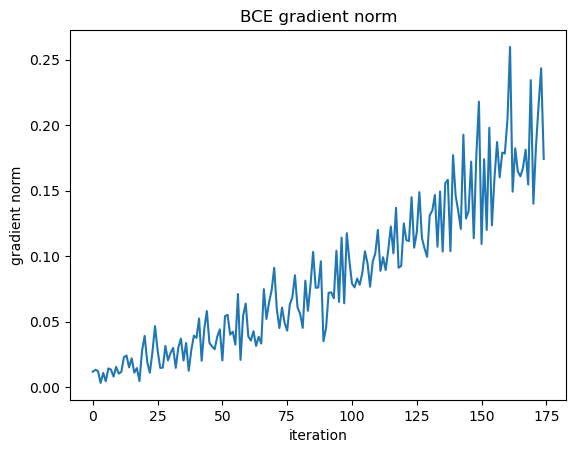

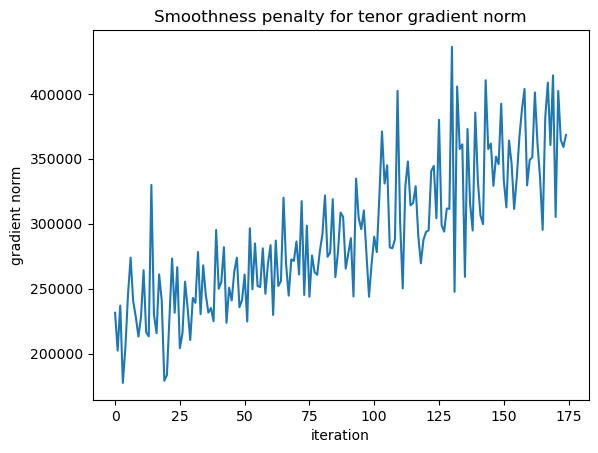

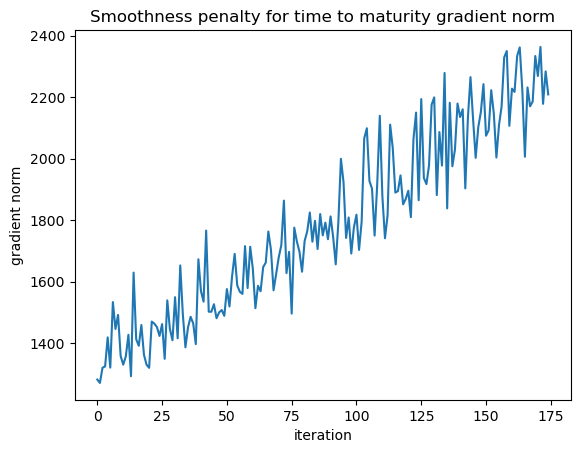

alpha : 2.691626746109055e-07 beta : 4.351463181600397e-05


In [141]:
gen,gen_opt,disc,disc_opt,criterion, alpha, beta = VGS.GradientMatchingPlot(gen,gen_opt,disc,disc_opt,criterion,condition_train,true_train,tenor,tau,tenors,taus,n_grad,lrg,lrd,batch_size,noise_dim,device, data_model=data_model)

### 4.2 Confidence Intervals

Here is sample code for producing many surfaces in a Monte Carlo manner and then extracting the confidence intervals for a specific underlying.

The example provided is the 1 Month Expiry and 1 Year Tenor Swaption.

Remember to load the correct generator parameters before utilizing this code.

In [35]:
n_test = true_test.shape[0]
underlying_dim = true_test.shape[1]
B = 10000

# collecting test surfaces from the generator

time_series_surfaces = []

print(f'Model: {data_model}')

with torch.no_grad():
    for l in tqdm(range(B)):
        #sample noise
        noise = torch.randn((n_test, underlying_dim, noise_dim), device=device,dtype=torch.float)
        #sample from the generator
        fake = gen(noise,condition_test[:,:,:])
        surface_past_test = condition_test[:,:,3:]

        #simulated implied vol surfaces as vectors
        if data_model == 'normal':
            fake_surface = fake[:,:,1:] + surface_past_test
        elif data_model == 'log':
            fake_surface = torch.exp(fake[:,:,1:] + surface_past_test)
    
        time_series_surfaces.append(fake_surface[:, 0, 0])

Model: log


100%|██████████| 10000/10000 [01:57<00:00, 84.75it/s]


In [36]:
Y1_M1_pred = pd.DataFrame(time_series_surfaces)
Y1_M1_pred = Y1_M1_pred.applymap(lambda x: x.item() if isinstance(x, torch.Tensor) else x)

In [37]:
percentile_2_5 = Y1_M1_pred.quantile(0.025).shift(1)
percentile_97_5 = Y1_M1_pred.quantile(0.975).shift(1)

percentile_df = pd.DataFrame({
    '2.5 percentile': percentile_2_5,
    '97.5 percentile': percentile_97_5
})

In [38]:
percentile_df.index = pd.to_datetime(dates_t[-n_test:])

In [39]:
true_surfaces = pd.read_excel(VOLATILITY_DATA, header=[0,1,2], index_col=0).sort_index()

true_surfaces.index = pd.to_datetime(true_surfaces.index)
true_surfaces = true_surfaces.loc[dates_t[-n_test]:]

In [40]:
percentile_df['true'] = true_surfaces.iloc[:, 0]

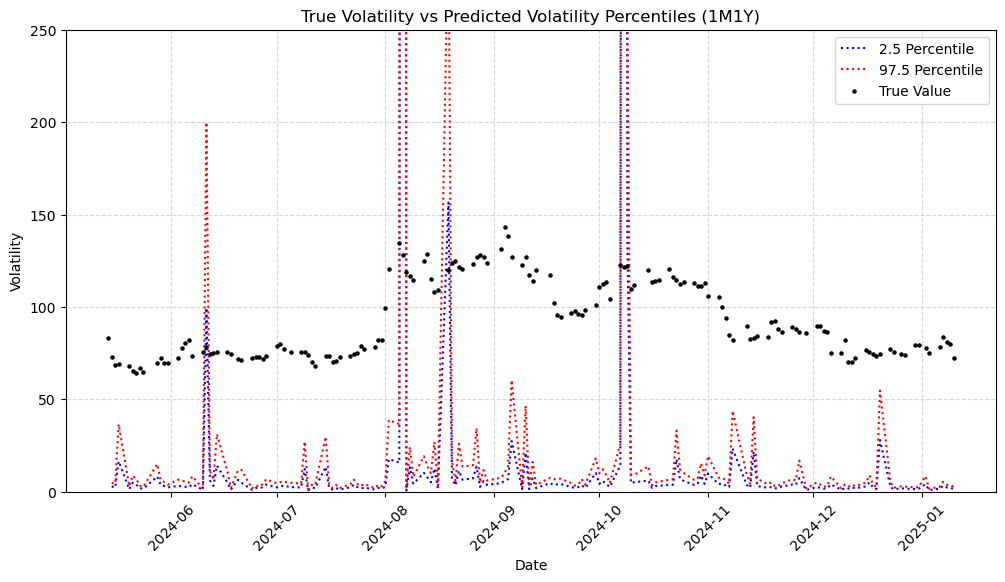

In [41]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(percentile_df.index, percentile_df["2.5 percentile"], linestyle="dotted", color="blue", label="2.5 Percentile")
plt.plot(percentile_df.index, percentile_df["97.5 percentile"], linestyle="dotted", color="red", label="97.5 Percentile")
plt.scatter(percentile_df.index, percentile_df["true"], color="black", label="True Value", zorder=3, s=5)

# Labels and Legend
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("True Volatility vs Predicted Volatility Percentiles (1M1Y)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)

#restrict y axis to 0-250
plt.ylim(0, 250)

# Show plot
plt.show()

In [42]:
# check if true value is within the 95% interval

check = (percentile_df['true'] > percentile_df['2.5 percentile']) & (percentile_df['true'] < percentile_df['97.5 percentile'])
check.value_counts()

False    164
Name: count, dtype: int64

### 4.3 Market Dynamics

Like the paper, we can evaluate the ability for the model to learn and the quality of the surfaces by using PCA to see whether or not it was able to learn market dynamics.

In [21]:
# get out of sample log increments for the true surfaces

true_surfaces = pd.read_excel(VOLATILITY_DATA, header=[0,1,2], index_col=0).sort_index()
true_surfaces.index = pd.to_datetime(true_surfaces.index)

true_surfaces = true_surfaces.loc[dates_t[-n_test]:]

#get log increments
true_surfaces_log = np.log(true_surfaces).diff().dropna()

In [22]:
past_log_surface = pd.DataFrame(condition_test[:,:,3:].squeeze())
diff = past_log_surface.diff().dropna()

In [23]:
# pca on the true surfaces log increments

from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(diff)

PCA(n_components=10)

In [ ]:
# get the explained variance for the true surface

pca.explained_variance_ratio_ * 100

array([71.04594   , 13.594114  ,  7.605908  ,  2.4986897 ,  1.3711593 ,
        0.9249522 ,  0.5850299 ,  0.40282533,  0.24599826,  0.21774876],
      dtype=float32)

In [25]:
n_test = true_test.shape[0]
underlying_dim = true_test.shape[1]
B = 1000

# collecting test surfaces from the generator

time_series_surfaces = []

print(f'Model: {data_model}')

first_component = []
second_component = []
third_component = []

with torch.no_grad():
    for l in tqdm(range(B)):
        #sample noise
        noise = torch.randn((n_test, underlying_dim, noise_dim), device=device,dtype=torch.float)
        #sample from the generator
        fake = gen(noise,condition_test[:,:,:])
        surface_past_test = condition_test[:,:,3:]

        #simulated implied vol surfaces as vectors
        if data_model == 'normal':
            fake_surface = fake[:,:,1:] + surface_past_test
        elif data_model == 'log':
            fake_surface = torch.exp(fake[:,:,1:] + surface_past_test)

        log_increments = fake[:,:,1:].squeeze()

        pca = PCA(n_components=10)
        pca.fit(log_increments)

        first_component.append(pca.explained_variance_ratio_[0])
        second_component.append(pca.explained_variance_ratio_[1])
        third_component.append(pca.explained_variance_ratio_[2])

Model: log


100%|██████████| 1000/1000 [01:01<00:00, 16.33it/s]


In [26]:
first_component = pd.Series(first_component)
second_component = pd.Series(second_component)
third_component = pd.Series(third_component)

In [28]:
first_mean, second_mean, third_mean = float(np.mean(first_component) * 100), float(np.mean(second_component) * 100), float(np.mean(third_component) * 100)
first_bounds, second_bounds, third_bounds = float(1.96 * np.std(first_component) * 100), float(1.96 * np.std(second_component) * 100), float(1.96 * np.std(third_component) * 100)

In [29]:
print('Explained variance ratios for the first three components for generated surfaces:')
print(f'First component: {first_mean:.2f} +/- {first_bounds:.2f}')
print(f'Second component: {second_mean:.2f} +/- {second_bounds:.2f}')
print(f'Third component: {third_mean:.2f} +/- {third_bounds:.2f}')

Explained variance ratios for the first three components for generated surfaces:
First component: 35.66 +/- 1.08
Second component: 3.94 +/- 0.47
Third component: 3.39 +/- 0.42
